In [8]:
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from joblib import load
from ruamel.yaml import YAML
from matplotlib import pyplot as plt
from scipy.stats import uniform, norm
import seaborn as sns
import numpy as np
import pandas as pd
import h5py

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV, ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from umda import paths

In [2]:
seed = 1215677
normalize = True
mask = False

In [3]:
def load_data(exclude_hydrogen: bool=True):
    data_path = paths.get("processed").joinpath("pipeline_embeddings_70.h5")
    tmc1_data = pd.read_pickle(paths.get("processed").joinpath("tmc1_ready.pkl"))
    if exclude_hydrogen:
        tmc1_data = tmc1_data.loc[tmc1_data["SMILES"] != "[HH]"]
    tmc1_data.reset_index(inplace=True, drop=True)
    with h5py.File(data_path, "r") as h5_data:
        X = h5_data["pca"][:]
        cluster_ids = h5_data["cluster_ids"][:]
    return X, cluster_ids, tmc1_data


def load_pipeline():
    model_path = paths.get("models")
    embedder = load(model_path.joinpath("EmbeddingModel.pkl"))
    return embedder


def cross_validation(data, estimator, hparams, seed, n_splits: int = 5, n_jobs: int = 16):
    X, y = data
    splitter = ShuffleSplit(n_splits, random_state=seed)
    # determine the distributions over which to do the CV search
    distributions = dict()
    for key, value in hparams.items():
        if all([type(val) == str for val in value]):
            distributions[f"regressor__{key}"] = value
        elif all([type(val) == bool for val in value]):
            distributions[f"regressor__{key}"] = value
        else:
            # remove all the string types
            temp = list()
            for val in value:
                try:
                    temp.append(float(val))
                except (ValueError, TypeError):
                    pass
            # draw Gaussian distribution
            distributions[f"regressor__{key}"] = norm(np.mean(temp), np.std(temp))
    # do a randomized CV search
    grid_search = RandomizedSearchCV(
        estimator,
        distributions,
        n_iter=1000,
        scoring="r2",
        cv=splitter,
        n_jobs=n_jobs,
        refit=False
    )
    result = grid_search.fit(X, y)
    return result


def standardized_fit_test(data, estimator, hparams, seed, n_splits: int = 100, test_size: float = 0.2):
    X, y = data
    splitter = ShuffleSplit(n_splits, test_size=test_size, random_state=seed)
    best_train_error, best_test_error, best_combined = np.inf, np.inf, np.inf
    log = list()
    for split_index, (train_index, test_index) in enumerate(splitter.split(X, y)):
        train_X, test_X, train_y, test_y = X[train_index], X[test_index], y[train_index], y[test_index]
        # current_estimator = estimator.__class__()
        # set the estimator hyperparameters
        estimator.__dict__.update(**{f"regressor__{key}": value for key, value in hparams.items()})
        result = estimator.fit(train_X, train_y)
        # compute the mean squared error
        train_error = mean_squared_error(train_y, result.predict(train_X))
        test_error = mean_squared_error(test_y, result.predict(test_X))
        combined_error = mean_squared_error(y, result.predict(X))
        r2 = r2_score(y, result.predict(X))
        log.append({"train_error": train_error, "test_error": test_error, "combined_error": combined_error, "r2": r2, "train_index": train_index, "test_index": test_index})
        if test_error < best_test_error:
            best_split = (train_index, test_index)
            best_train_error = train_error
            best_test_error = test_error
            best_combined = combined_error
            best_estimator = result
    return best_estimator, best_train_error, best_test_error, best_split, log


def compose_model(base_estimator, scale: bool = False):
    if scale:
        models = [
            ("scaler", StandardScaler()), ("regressor", base_estimator)
        ]
    else:
        models = [("regressor", base_estimator)]
    return Pipeline(models)

In [9]:
state = np.random.default_rng(seed)

full_X, full_cluster_ids, tmc1_df = load_data()
embedder = load_pipeline()

tmc1_X = np.vstack([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
tmc1_y = np.log10(tmc1_df["Column density (cm^-2)"].to_numpy())

In [10]:
with open("model_hparams.yml") as read_file:
    hparams = YAML().load(read_file)

In [11]:
gp_kernel = kernels.ConstantKernel() * \
    kernels.RBF(3.0, (1e-1, 10.0)) + \
    kernels.RationalQuadratic(200.0, 20.0, alpha_bounds=(1e-3, 5e2), length_scale_bounds=(50.0, 1e4)) * \
        kernels.ConstantKernel() + kernels.ConstantKernel()

In [12]:
base_models = {
    "linear_regression": LinearRegression(),
    "ridge": Ridge(),
    "svr": SVR(),
    "br": BayesianRidge(),
    "knn": KNeighborsRegressor(),
    "rfr": RandomForestRegressor(random_state=seed),
    "gbr": GradientBoostingRegressor(random_state=seed),
    "gpr": GaussianProcessRegressor(
        kernel=gp_kernel, random_state=seed
    )
}

models = {key: compose_model(value, normalize) for key, value in base_models.items()}

In [74]:
# generalized workflow
model_results = dict()
best_models = dict()
cv_results = dict()
for name in models.keys():
    model = models.get(name)
    hparam = hparams.get(name)
    # do CV to optimize hyperparameters
    cv_grid = cross_validation((tmc1_X, tmc1_y), model, hparam, seed, n_jobs=32)
    print(f"Model: {name} best CV score: {cv_grid.best_score_:.4e}")
    # refit best hyperparameters to exhaustive shuffle-split, getting best
    # generalization error
    best_estimator, best_train, best_test, best_index, log = standardized_fit_test((tmc1_X, tmc1_y), model, cv_grid.best_params_, seed, n_splits=100)
    # save results to dictionaries
    model_results[name] = log
    best_models[name] = best_estimator
    cv_results[name] = cv_grid

ing: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklear

In [611]:
# export the cross-validation results
for name in models.keys():
    df = pd.DataFrame(cv_results[name].cv_results_)
    keys = ["mean_test_score", "rank_test_score"]
    keys.extend([key for key in df.keys() if "param_" in key])
    df = df[keys]
    # sort and reset the indices
    df.sort_values("rank_test_score", ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    # dump to CSV file
    if normalize:
        flags = "norm"
    else:
        flags = "unnorm"
    if mask:
        flags += "_mask"
    else:
        flags += "_nomask"
    df.to_csv(f"outputs/random_search/{name}_{flags}.csv", index=False)

In [75]:
cv_results["gbr"].best_params_

{'regressor__learning_rate': 0.06548486552587539,
 'regressor__max_depth': 4.179297568468887,
 'regressor__min_samples_leaf': 0.14804033043277728,
 'regressor__min_samples_split': 0.7856363465201324,
 'regressor__n_estimators': 82.51002541389911,
 'regressor__subsample': 0.48742318290805275}

In [76]:
pd.DataFrame(model_results["knn"]).sort_values(["r2", "combined_error"], ascending=[False, True])

,train_error,test_error,combined_error,r2,train_index,test_index
3,0.619312,0.946486,0.687003,0.307648,"[59, 10, 31, 21, 37, 25, 23, 70, 42, 46, 82, 9...","[13, 64, 4, 52, 60, 14, 32, 20, 8, 76, 39, 86,..."
70,0.586049,1.140898,0.700845,0.293698,"[11, 33, 35, 34, 57, 15, 49, 25, 60, 38, 23, 8...","[13, 3, 31, 77, 78, 44, 46, 84, 76, 1, 5, 28, ..."
31,0.616622,1.029960,0.702140,0.292393,"[72, 46, 33, 62, 53, 32, 38, 41, 66, 84, 24, 3...","[17, 12, 57, 42, 22, 83, 25, 64, 23, 86, 9, 11..."
87,0.613011,1.054108,0.704273,0.290244,"[57, 32, 27, 60, 2, 31, 0, 36, 24, 13, 68, 62,...","[70, 4, 52, 45, 41, 58, 85, 76, 43, 53, 28, 3,..."
98,0.703494,0.709827,0.704804,0.289708,"[31, 3, 58, 6, 76, 20, 70, 29, 30, 75, 24, 47,...","[28, 8, 77, 41, 38, 19, 46, 0, 5, 34, 49, 33, ..."
...,...,...,...,...,...,...
13,0.731363,1.209469,0.830282,0.163254,"[10, 75, 37, 43, 16, 25, 24, 1, 30, 11, 85, 20...","[60, 26, 65, 83, 53, 23, 27, 32, 54, 21, 78, 5..."
24,0.814871,0.891372,0.830699,0.162833,"[56, 26, 35, 85, 77, 13, 83, 0, 28, 4, 22, 15,...","[16, 69, 53, 71, 50, 59, 6, 37, 81, 55, 1, 20,..."
49,0.706437,1.344947,0.838542,0.154929,"[6, 15, 49, 34, 58, 48, 44, 55, 50, 54, 37, 42...","[61, 72, 7, 30, 51, 73, 70, 23, 81, 25, 36, 28..."
23,0.640719,1.649567,0.849446,0.143940,"[67, 0, 80, 60, 73, 66, 72, 11, 32, 84, 6, 57,...","[28, 48, 83, 49, 52, 35, 17, 33, 79, 37, 64, 2..."


[(10.0, 15.0), (10.0, 15.0)]

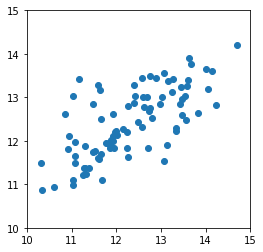

In [79]:
num_models = len(hparams)

fig, axarray = plt.subplots(2, num_models // 2, figsize=(10, 4), sharex=True, sharey=True)

for model_name, ax in zip(models.keys(), axarray.flatten()):
    ax.scatter(tmc1_y, best_models.get(model_name).predict(tmc1_X))
    ax.set(xlim=[10, 15], ylim=(10, 15))
    ax.set_title(model_name, loc="left")

## Data importance estimation

In [599]:
def bootstrap_importance_estimation(estimator, data, seed: int, n_splits: int = 500):
    X, y = data
    splitter = ShuffleSplit(n_splits, test_size=0.2, random_state=seed)
    log = list()
    weights = np.ones((n_splits, y.size))
    test_errors = list()
    for split_index, (train_index, test_index) in enumerate(splitter.split(X, y)):
        train_X, test_X, train_y, test_y = X[train_index], X[test_index], y[train_index], y[test_index]
        result = estimator.fit(train_X, train_y)
        # compute the mean squared error
        train_error = mean_squared_error(train_y, result.predict(train_X))
        test_error = mean_squared_error(test_y, result.predict(test_X))
        log.append(
            {"train_error": train_error, "test_error": test_error, "train_index": train_index, "test_index": test_index}
        )
        test_errors.append(test_error)
        weights[split_index, test_index] = 0.
    # reshape so we can do matrix multiplication
    test_errors = np.asarray(test_errors)[:,None]
    molecule_weights = (weights * test_errors).std(axis=0)
    molecule_weights /= np.min(molecule_weights)
    return log, molecule_weights

In [600]:
bootstrap_log, weights = bootstrap_importance_estimation(best_models["ridge"], (tmc1_X, tmc1_y) ,seed, n_splits=5000)